# YOLO
The goal of this notebook is to do transfer learning of Fishial´s already implemented YOLO model. We do this by using Ultralytics

In [ ]:
!pip install ultralytics

In [4]:
from ultralytics import YOLO
import os
import requests
import logging
from zipfile import ZipFile
import pandas as pd
import torch
import cv2
import matplotlib.pyplot as plt
import copy
from IPython.display import Image, display

from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [5]:
DATA_DIR = "../data_csv/"
timor_leste_data_path = os.path.join(DATA_DIR, "timor-leste.csv") # Annotation info for ground truth
images_path = "../data_images/"

In [6]:
# Filter out relevant images
relevant_species = ['Alectis ciliaris', 'Aphareus rutilans', 'Caranx ignobilis', 'Caranx lugubris', 'Caranx melampygus', 'Caranx sexfasciatus', 'Chirocentrus dorab', 'Chirocentrus nudus', 'Decapterus macrosoma', 'Elagatis bipinnulata', 'Epinephelus maculatus', 'Epinephelus radiatus', 'Etelis carbunculus', 'Gymnocranius grandoculis', 'Katsuwonus pelamis', 'Lethrinus atkinsoni', 'Lethrinus erythracanthus', 'Lethrinus obsoletus', 'Lethrinus ornatus', 'Lutjanus bohar', 'Lutjanus fulviflamma', 'Lutjanus fulvus', 'Lutjanus gibbus', 'Lutjanus johnii', 'Lutjanus kasmira', 'Lutjanus rivulatus', 'Lutjanus russellii', 'Lutjanus timoriensis', 'Monotaxis grandoculis', 'Psettodes erumei', 'Rastrelliger kanagurta', 'Sardinella albella', 'Scolopsis lineata', 'Scolopsis vosmeri', 'Scomberoides lysan', 'Scomberomorus commerson', 'Seriola dumerili', 'Variola albimarginata']

# Read annotation info (Timor-leste)
df_tl_ann = pd.read_csv(timor_leste_data_path, encoding="utf-8-sig", header=0, skiprows=1)
df_tl_ann = df_tl_ann[["image_file", "catch_name_en", "Species_name", "Family"]]

# Filter by species in relevant_species
df_filtered = df_tl_ann[df_tl_ann["Species_name"].isin(relevant_species)]

# Keep only images that actually exist
existing_files = set(os.listdir(images_path))

df_filtered = df_filtered[df_filtered["image_file"].isin(existing_files)]

# Convert to list of filenames
filtered_images= df_filtered["image_file"].tolist()

print("Total annotated images:", len(df_tl_ann))
print("Relevant images", len(df_filtered))
print("Unique final JPGs:", len(set(filtered_images)))


Total annotated images: 603
Relevant images 248
Unique final JPGs: 217


In [ ]:
# Load a pretrained YOLO11n model
model = YOLO("yolo11n-cls.pt")

# Train the model
train_results = model.train(
    data="dataset",
    epochs=1,
    imgsz=640,
    device="cpu",
)

# Evaluate the model's performance on the validation set
metrics = model.val()

display(Image(filename="runs/classify/train2/results.png"))
display(Image(filename="runs/classify/val/confusion_matrix.png"))

# Perform object detection on an image
for image in filtered_images[:10]:
  results = model(DATA_DIR + "/timor_leste/" + image)
  results[0].show()

New https://pypi.org/project/ultralytics/8.3.235 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.234  Python-3.12.12 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-12500)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=Fals

FileNotFoundError: [Errno 2] No such file or directory: 'runs/classify/train/results.png'

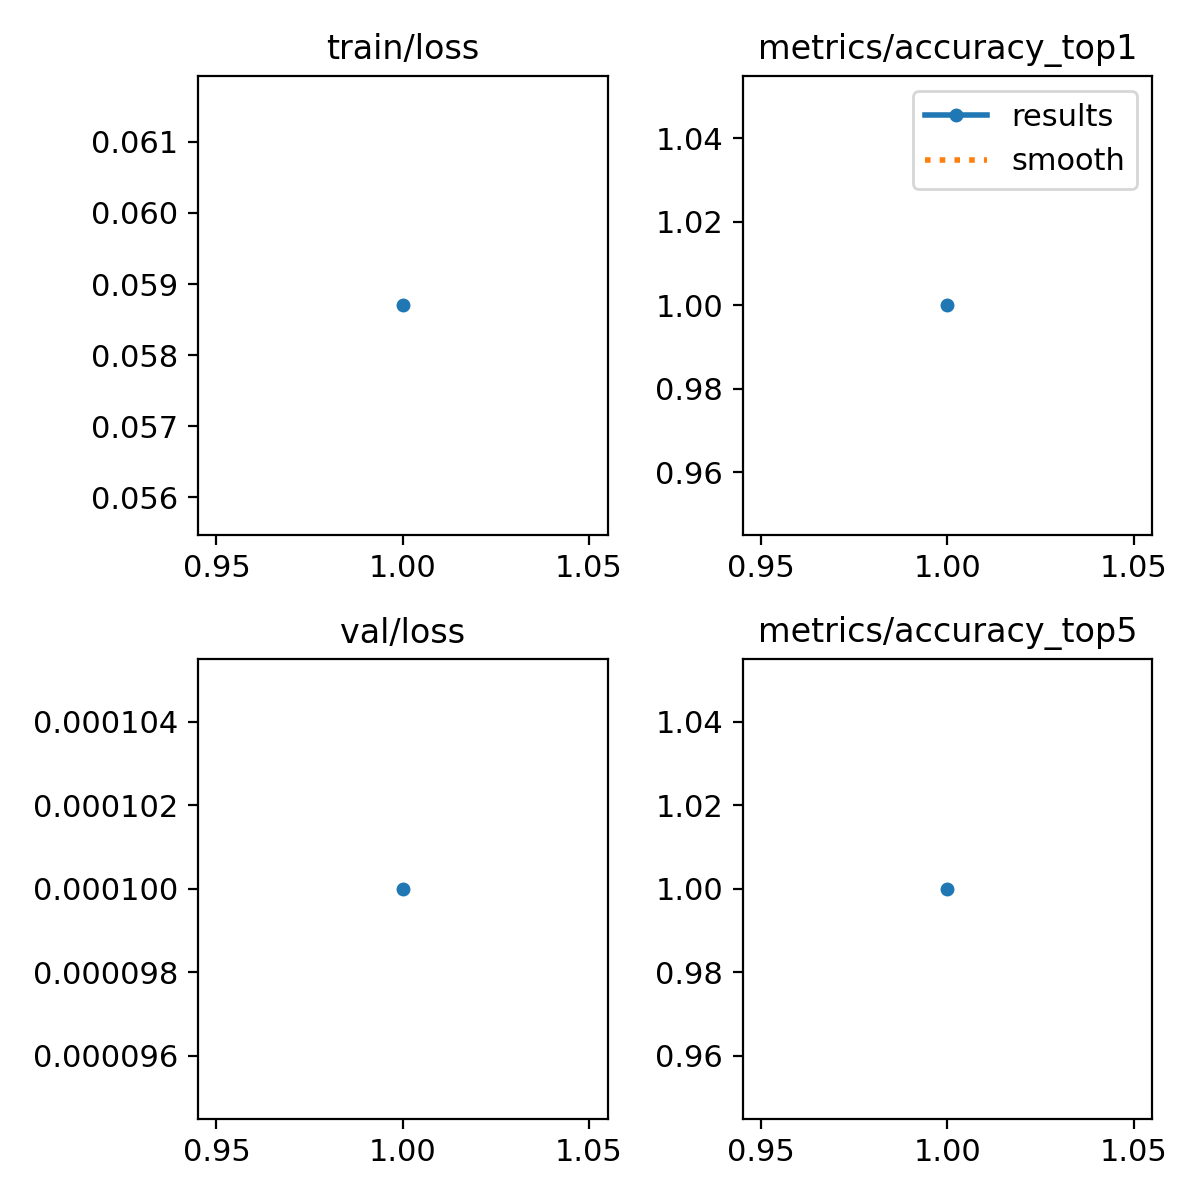

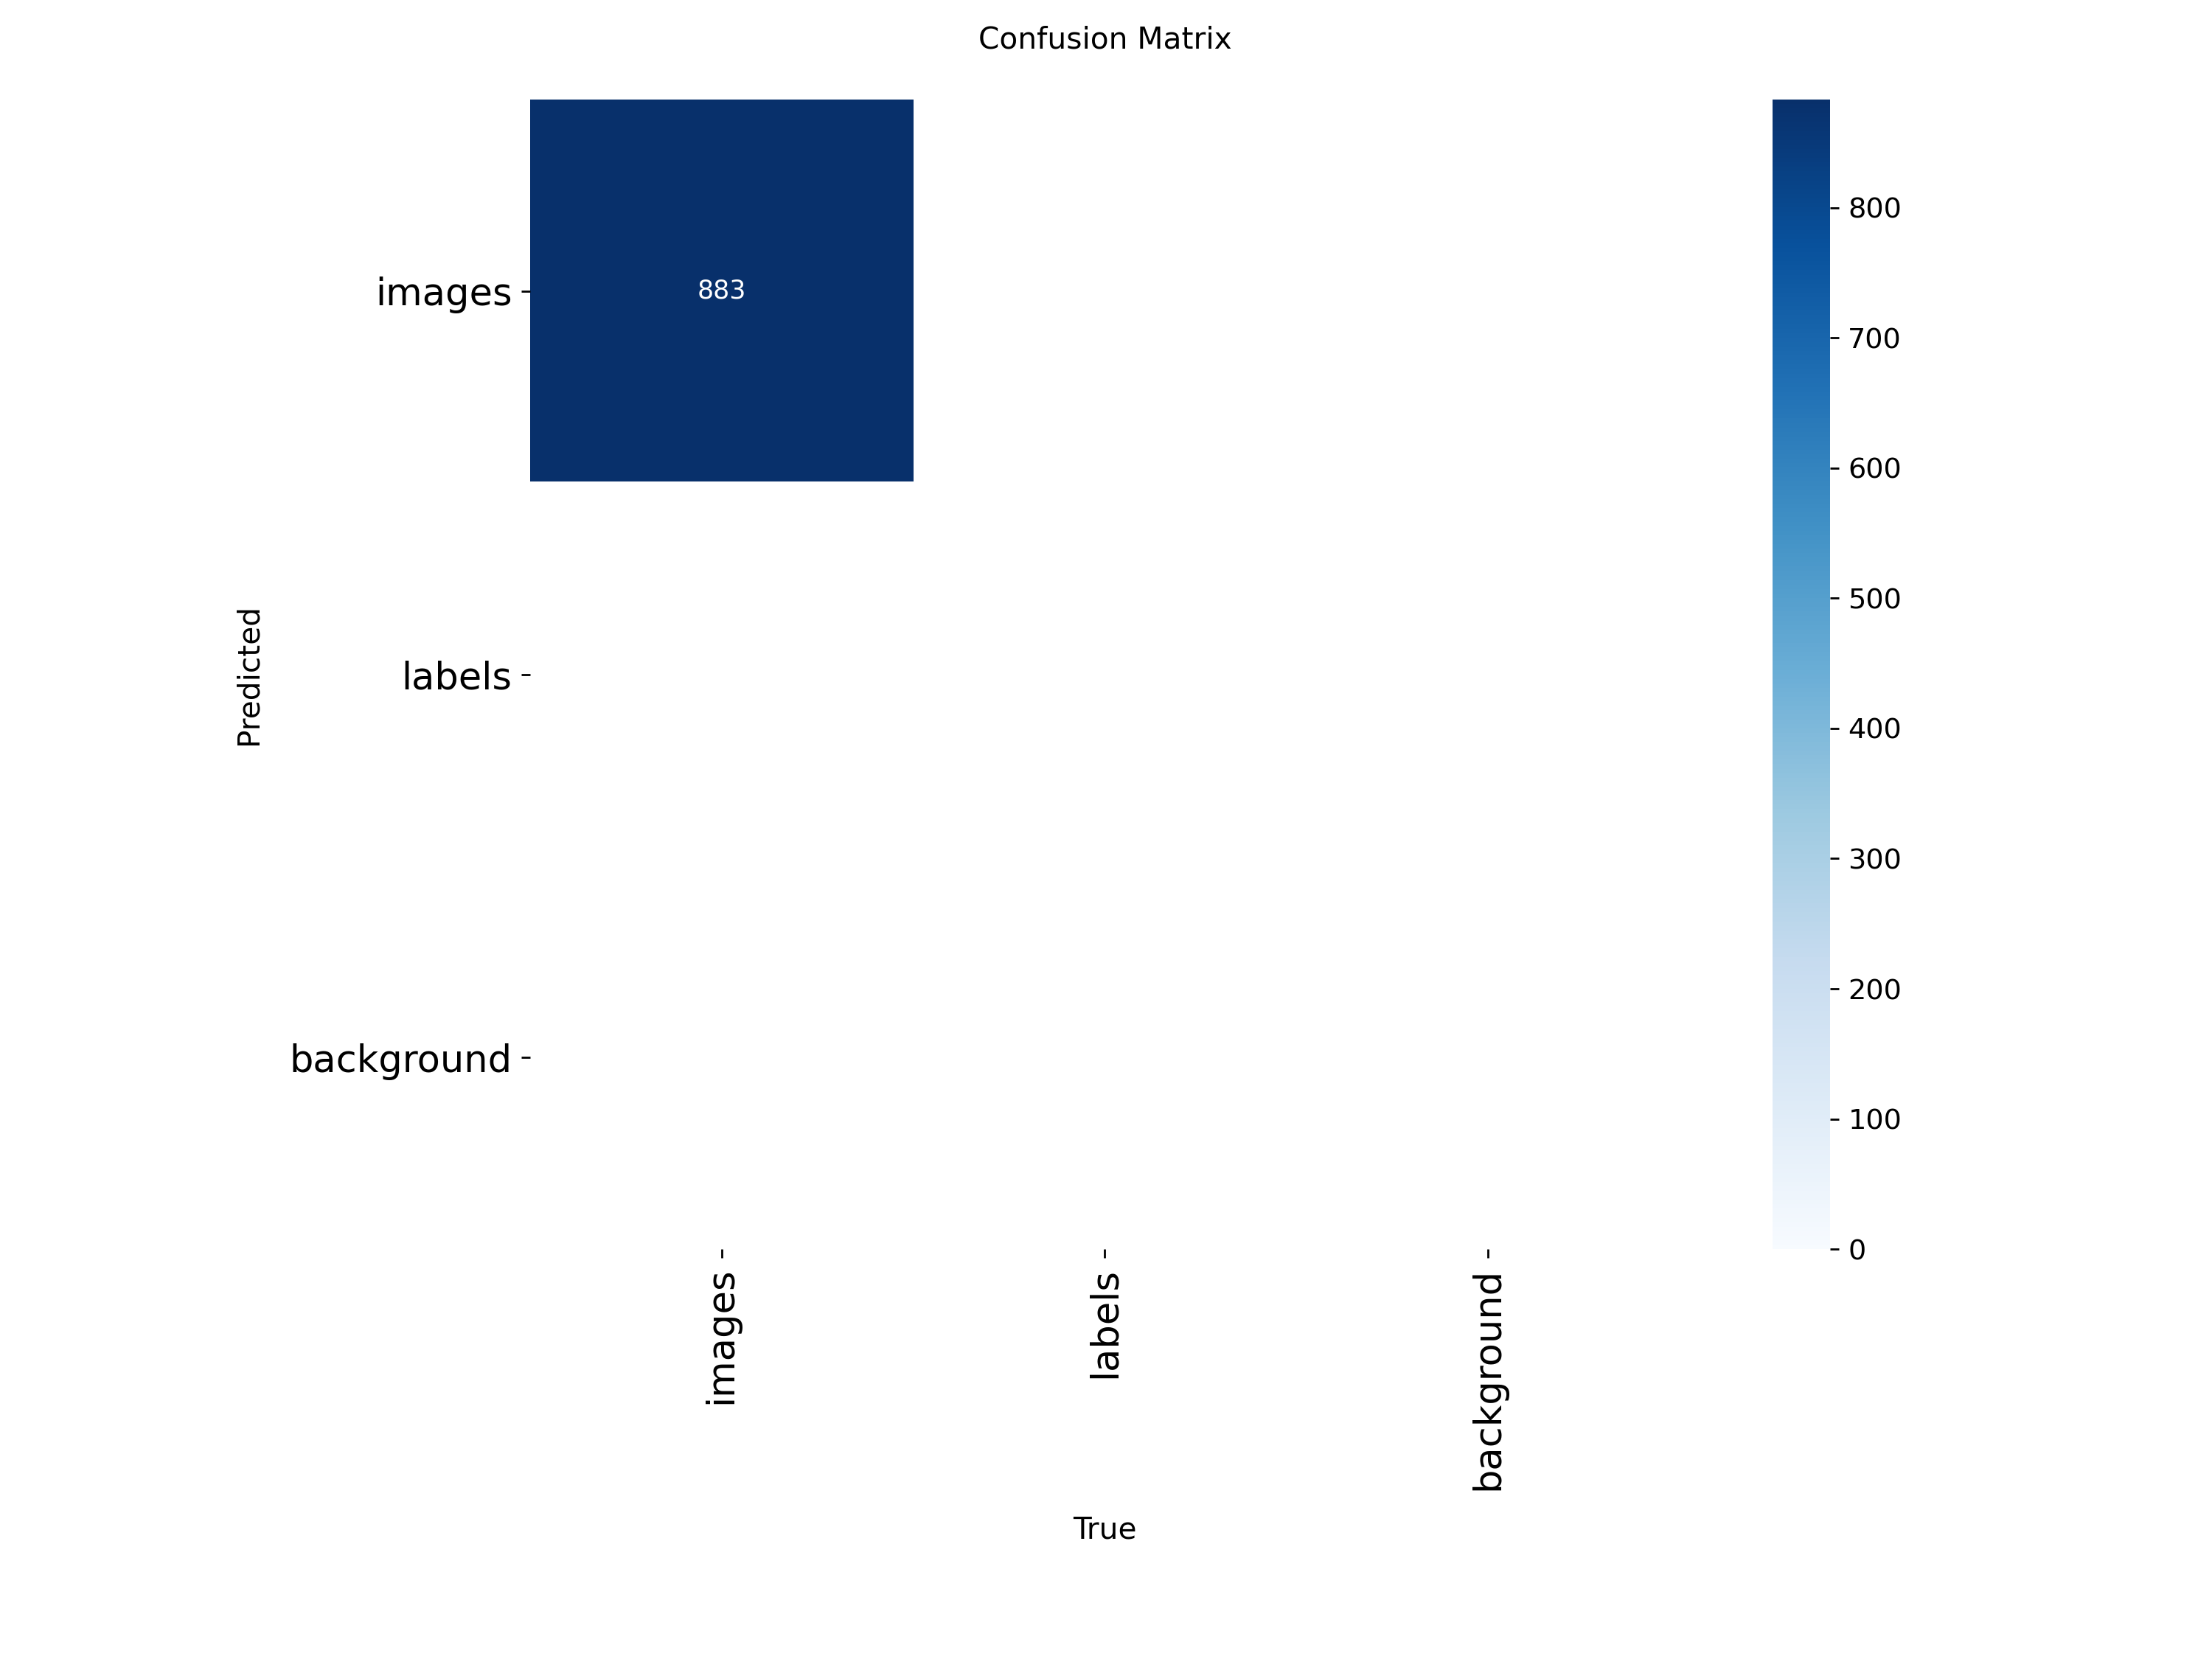

In [9]:
display(Image(filename="runs/classify/train2/results.png"))
display(Image(filename="runs/classify/val/confusion_matrix.png"))

In [ ]:

MODEL_PATH = "yolo11n.pt"         # or your best checkpoint
IMAGES_DIR = "data_images"        # folder with input images
OUT_DIR = "runs/inference_out"    # where to save annotated images
CSV_OUT = os.path.join(OUT_DIR, "detections.csv")
IMGSZ = 640
BATCH = 8                         # increase until you hit GPU memory limit
CONF_THR = 0.25                   # minimum confidence to keep
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FONT = cv2.FONT_HERSHEY_SIMPLEX
THICKNESS = 2
SCALE = 0.6

os.makedirs(OUT_DIR, exist_ok=True)

# --- Load model (auto uses GPU if available) ---
model = YOLO(MODEL_PATH)
model.fuse()                        # fuse for slightly faster inference (if supported)
model.to(DEVICE)
if DEVICE == "cuda":
    model.model.half()              # run in FP16 for speed if GPU supports it

# --- Prepare image list ---
image_paths = sorted([str(p) for p in Path(IMAGES_DIR).glob("*") if p.suffix.lower() in [".jpg",".jpeg",".png"]])
if len(image_paths) == 0:
    raise SystemExit("No images found in " + IMAGES_DIR)

# --- Run batch prediction ---
# Use model.predict for batch inference. It returns a sequence of Result objects in same order as inputs.
results = model.predict(
    source=image_paths,
    imgsz=IMGSZ,
    batch=BATCH,
    device=DEVICE,
    conf=CONF_THR,
    verbose=False,   # set True if you want per-image logs similar to prior
    half=(DEVICE=="cuda")  # use half precision on GPU
)

# --- Iterate results and draw / save detections ---
rows = []  # for csv: filename, x1,y1,x2,y2,label,conf

for img_path, res in zip(image_paths, results):
    img = cv2.imread(img_path)  # BGR
    if img is None:
        print("Failed to read", img_path); continue

    # res.boxes may be empty; use len() to check
    boxes = res.boxes
    if boxes is None or len(boxes) == 0:
        # optionally write the image unchanged or with "no detections"
        out_file = os.path.join(OUT_DIR, Path(img_path).name)
        cv2.putText(img, "No detections", (10, 30), FONT, 1.0, (0,0,255), 2, cv2.LINE_AA)
        cv2.imwrite(out_file, img)
        continue

    # extract arrays (move to cpu if tensors)
    xyxy = boxes.xyxy.cpu().numpy()        # shape (N,4) x1,y1,x2,y2 (float)
    cls  = boxes.cls.cpu().numpy().astype(int)   # class ids
    conf = boxes.conf.cpu().numpy()        # confidences

    for (x1, y1, x2, y2), c, p in zip(xyxy, cls, conf):
        label = model.names[int(c)] if hasattr(model, "names") else str(int(c))
        conf_text = f"{p:.2f}"

        # draw rectangle
        color = (255, 0, 0)  # BGR (blue). Pick color per class if you want.
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, THICKNESS)

        # label box (text background)
        text = f"{label} {conf_text}"
        (tw, th), _ = cv2.getTextSize(text, FONT, SCALE, THICKNESS)
        # draw filled rectangle for text background
        cv2.rectangle(img, (int(x1), int(y1)-th-6), (int(x1)+tw, int(y1)), color, -1)
        # put white text
        cv2.putText(img, text, (int(x1), int(y1)-4), FONT, SCALE, (255,255,255), THICKNESS//2, cv2.LINE_AA)

        # record row
        rows.append({
            "image_file": Path(img_path).name,
            "x1": float(x1), "y1": float(y1), "x2": float(x2), "y2": float(y2),
            "label": label, "conf": float(p)
        })

    # save annotated image
    out_file = os.path.join(OUT_DIR, Path(img_path).name)
    cv2.imwrite(out_file, img)

# --- Save CSV with all detections ---
if rows:
    df = pd.DataFrame(rows)
else:
    df = pd.DataFrame(columns=["image_file","x1","y1","x2","y2","label","conf"])
df.to_csv(CSV_OUT, index=False)
print("Saved annotated images to:", OUT_DIR)
print("Saved detections CSV to:", CSV_OUT)



image 1/1 c:\Users\kiennd\Desktop\Prosjektoppgave\yolo\..\data_images\1689120590238.jpg: 640x640 images 1.00, labels 0.00, 38.3ms
Speed: 16.1ms preprocess, 38.3ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\kiennd\Desktop\Prosjektoppgave\yolo\..\data_images\1689388044927.jpg: 640x640 images 1.00, labels 0.00, 30.9ms
Speed: 15.2ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\kiennd\Desktop\Prosjektoppgave\yolo\..\data_images\1689388326411.jpg: 640x640 images 1.00, labels 0.00, 29.5ms
Speed: 14.5ms preprocess, 29.5ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\kiennd\Desktop\Prosjektoppgave\yolo\..\data_images\1689557063983.jpg: 640x640 images 1.00, labels 0.00, 91.2ms
Speed: 19.1ms preprocess, 91.2ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\kiennd\Desktop\Prosjektoppgave\yolo\..\data_images\1689557783158